<a href="https://colab.research.google.com/github/FentonLab/webChronux/blob/master/Pac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import numpy as np
import os
import sys
import traceback
from scipy.io import loadmat
import math
import scipy.signal as signal
from scipy.signal import *
import matplotlib.pyplot as plt
from numpy import cos, sin, pi, absolute, arange
from numpy.random import normal
from scipy.signal import kaiserord, lfilter, firwin, freqz
from math import sqrt, log10
from google.colab import drive
drive.mount('/content/drive')

def getMI(amp, phase, edges):

    '''
    compute modulation index as shown in Tort 2010
    Original Matlab code by Dino Dvorak 2012 dino@indus3.net
    Python version by Siddhartha Mitra 2017 mitra.siddhartha@gmail.com
    Input:
         - amp: Amplitude
         - phase: Phase
         - edges: Edges
    Output:
         - MI
    '''

    MI = ''

    try:

        h = []

        for hi in range ( len(edges) - 1 ):

            k = [ 1 if x >= edges[hi] and x < edges[hi+1] else 0 for x in phase]

            if sum(k) > 0: # only if there are some values, otherwise keep zero
                print (sum([x for i,x in enumerate(amp) if k[i] == 1 ]))
                h.append( np.mean([x for i,x in enumerate(amp) if k[i] == 1 ])) # mean of amplitudes at that phase bin
            else:
                h.append(0)

        ## convert to probability
        h = h / sum(h)

        ## calculate modulation index
        Hp = -1 * sum( [x*np.log(x) for x in h]) # entropy of the histogram
        #print ( " Hp = " + str(Hp) )

        D = np.log(len(h)) - Hp
        #print ( " D = " + str(D) )

        MI = D / np.log(len(h))
        #print ( " MI = " + str(MI) )

    except:
        traceback.print_exc(file=sys.stdout)

    return MI


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def calcPAC(filePath, samplingFrequency, start, stop, hcut, lcut, ripple_db, bw, attenHz):

  try:

    eegData = loadmat(filePath)

    eegFS = 250 # sampling frequency

    eegData = eegData["eegData"]

    eeg1 = eegData[14]

    print ( eeg1[:5])

    eeg1 = eeg1[50 * eegFS - 1 : 80 * eegFS - 1 ]

    eeg1 = eeg1 - np.mean(eeg1, axis = 0)

    eeg2 = eegData[15]

    print ( eeg2[:5])

    eeg2 = eeg2[start * eegFS - 1 : stop * eegFS - 1 ]

    eeg2 = eeg2 - np.mean(eeg2, axis = 0)

    # edges for phase
    edges = np.linspace(-math.pi,math.pi,21)

    x = np.linspace(0,200,5000);

    s1 = np.sin( x * pi / 180 )

    s2 = np.sin( x * pi / 18 )

    s2 = np.array ( [x*y for x,y in zip(s1,s2) ] )

    s3 = s1 + s2

    eeg = s3

    # lcut = 9.0
    # hcut = 13.0

    #----------------------------------------------------------
    # Set the sampling frequency to 100. Sample period is 0.01.
    # A frequency of 1 will have 100 samples per cycle, and
    # therefore have 4 cycles in the 400 samples.

    sample_rate = samplingFrequency
    nyq = sample_rate / 2.0
    width = 2.0/nyq # pass to stop transition width

    # The desired attenuation in the stop band, in dB.
    # ripple_db = 40.0

    # Compute the order and Kaiser parameter for the FIR filter.
    N, beta = kaiserord(ripple_db, width)

    #print ('N = ',N, 'beta = kaiser param = ', beta)

    # The cutoff frequency of the filter.
    cutoff_hz = lcut

    winLen = N
    # to be in conformance with MATLAB ( check documentation of fir1 in MATLAB, it automatically adds 1 for even sized windows)
    if N % 2 ==0:
            winLen = N + 1

    # Use firwin with a Kaiser window to create a lowpass FIR filter.
    hpftaps = firwin(winLen, cutoff_hz/nyq, window=('kaiser', beta), pass_zero=False)

    #----------------------------------------------------------
    # now create the taps for a high pass filter.
    # by multiplying tap coefficients by -1 and
    # add 1 to the centre tap ( must be even order filter)

    hpftaps = [-1*a for a in hpftaps]
    print ( len(hpftaps))
    midPoint = int(np.round(len(hpftaps)/2))
    if midPoint % 2 != 0:
        midPoint = midPoint -1
    hpftaps[midPoint] = hpftaps[midPoint] + 1

    #----------------------------------------------------------
    # Now calculate the tap weights for a lowpass filter at say 15hz

    cutoff_hz = hcut

    lpftaps = firwin(winLen, cutoff_hz/nyq, window=('kaiser', beta), pass_zero=False)

    # Subtract 1 from lpf centre tap for gain adjust for hpf + lpf
    lpftaps[midPoint] = lpftaps[midPoint] - 1

    taps = [sum(pair) for pair in zip(hpftaps, lpftaps)]

    denom = [0]*len(taps)
    denom[0] = 1

    [a,f] = group_delay( [ taps , denom ] , int(nyq))

    bAlpha = taps
    bAlphax = np.array(a) * sample_rate/(2*math.pi)

    k = [f[i] for i,m in enumerate(bAlphax) if m >= 9 and m <= 13]

    gdAlpha = math.floor(np.mean(k))

    fGamma = np.arange(20,101,5)

    # bw = 20 #bandwidth
    attendB = ripple_db #attenuation
    # attenHz = 4 #transition band

    filtersGamma = {}

    for fI in range ( len(fGamma) ):

        lcut = fGamma[fI]-bw/2
        hcut = fGamma[fI]+bw/2

        Fstop1 = (lcut - attenHz)  / nyq
        Fpass1 = lcut  / nyq
        Fpass2 = hcut / nyq

        Fstop2 = (hcut + attenHz) / nyq
        Astop1 = attendB
        Apass  = 1
        Astop2 = attendB

        #################
        hpftaps = firwin(N, lcut/nyq, window=('kaiser', beta))
        hpftaps = [-1*a for a in hpftaps]

        midPoint = int(np.round(len(hpftaps)/2))
        if midPoint % 2 != 0:
            midPoint = midPoint -1

        hpftaps[midPoint] = hpftaps[midPoint] + 1

        lpftaps = firwin(N, hcut/nyq, window=('kaiser', beta))
        lpftaps[midPoint] = lpftaps[midPoint] - 1

        taps = [sum(pair) for pair in zip(hpftaps, lpftaps)]

        denom = [0]*len(taps)
        denom[0] = 1

        [a,f] = group_delay( [ taps , denom ] , int(nyq))

        x = np.array(a) * sample_rate/(2*math.pi)

        k = [f[i] for i,m in enumerate(x) if m >= 9 and m <= 13]
        val = math.floor(np.mean(k))
        #################

        filtersGamma[fI] = []

        filtersGamma[fI].append (taps)
        filtersGamma[fI].append (val)

    PLVs = []

    ##amplitude for gamma range + MI
    for key, value in filtersGamma.items():

        #amplitude
        amp1 = lfilter(value[0],1,eeg1)
        amp2 = lfilter(value[0],1,eeg2)
        gd = value[1]

        amp1 = np.append(amp1[gd+1:], np.zeros(gd))
        amp2 = np.append(amp2[gd+1:], np.zeros(gd))

        ph1 = np.angle(hilbert(amp1))
        ph2 = np.angle(hilbert(amp2))

        print(" ph1 = " + str(ph1))
        print(" ph2 = " + str(ph2))

        phd = ph1 - ph2
        #compute raw modulation index

        PLVs.append((1/len(phd))*(abs(sum(np.exp(1j*phd)))))

  except:
      traceback.print_exc(file=sys.stdout)
  return fGamma, PLVs 


[6.71595335e-05 6.71595335e-05 6.71595335e-05 6.71595335e-05
 6.71595335e-05]
[6.71595335e-05 6.71595335e-05 6.71595335e-05 6.71595335e-05
 6.71595335e-05]
281
 ph1 = [2.08893641 2.62588669 3.09846841 ... 1.57079633 1.57079633 1.57079633]
 ph2 = [-0.20574666  0.84592978  1.34746725 ... -1.57079633  1.57079633
 -1.57079633]
Traceback (most recent call last):
  File "<ipython-input-16-bb7c700241df>", line 181, in calcPAC
    phd = ph1 - ph2
ValueError: operands could not be broadcast together with shapes (7499,) (1249,) 
 MIs = []


/usr/local/lib/python3.6/dist-packages/scipy/signal/filter_design.py:685: UserWarning: The group delay is singular at frequencies [0.000], setting to 0
  format(", ".join("{0:.3f}".format(ws) for ws in w[singular]))


ValueError: ignored

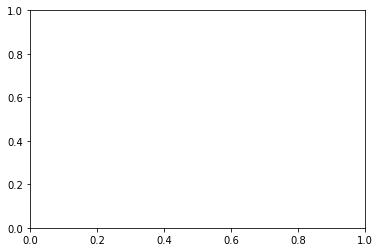

In [17]:
filePath = '/content/drive/My Drive/andre/EEG181.mat'
samplingFrequency = 250
start = 5 
stop = 10
hcut = 13.0
lcut = 9.0
ripple_db = 40.0
bw = 2
# transition bancd
attenHz = 4
fGamma, PLVs = calcPAC(filePath, samplingFrequency, start, stop, hcut, lcut, ripple_db, bw, attenHz)

print ( " MIs = " + str(PLVs))
plt.plot(fGamma,PLVs)
plt.show()

#print ( [str(k) + ":" + str(v[1]) + "-" + str(v[0][:5]) for k,v in filtersGamma.items() ]  )


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
